In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
matplotlib.rcParams.update({ "pgf.texsystem": "pdflatex", 'font.family': 'serif', 'pgf.rcfonts': False,
                            "savefig.transparent" : True,  "svg.fonttype": 'none',  })
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc("svg", fonttype='none')
plt.rc('text.latex', preamble=
       r'\usepackage{amsmath}'\
       + "\n" + r'\usepackage{amssymb}'
       )
import matplotlib.figure, matplotlib.axes
import sys
import numpy as np
import pickle as pkl
import tqdm
import collections.abc
import torch
from utils import PredictionResults, color
import os
import matplotlib.transforms
import matplotlib.artist
import matplotlib.collections
import matplotlib.lines
import matplotlib.axes
import matplotlib.figure
from matplotlib.gridspec import GridSpec
from scipy.spatial.transform import Rotation
import yaml 
import torch.utils.data as torchdata
print(os.getenv("PYTHONPATH"))
print(sys.path)

from deepracing_models.data_loading import SubsetFlag
import deepracing_models.math_utils as mu
import deepracing_models.data_loading.file_datasets as FD
import deepracing_models.data_loading.utils.file_utils as file_utils

/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch:/home/deepracing/trent/deepracingws/src/deepracing/deepracing_py:/home/deepracing/trent/deepracingws/src/deepracing_ros/deepracing_rclpy:
['/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch', '/home/deepracing/trent/deepracingws/src/deepracing/deepracing_py', '/home/deepracing/trent/deepracingws/src/deepracing_ros/deepracing_rclpy', '/home/deepracing/trent/deepracingws/src/deepracing/DCNN-Pytorch/plotting', '/home/deepracing/trent/python310/lib/python310.zip', '/home/deepracing/trent/python310/lib/python3.10', '/home/deepracing/trent/python310/lib/python3.10/lib-dynload', '', '/home/deepracing/trent/venvs/deepracing310/lib/python3.10/site-packages']


In [2]:
keys : set = {
    "hist",
    "hist_tangents",
    "hist_quats",
    "hist_vel",
    "fut",
    "fut_quats",
    "fut_vel",
    "left_bd",
    "right_bd",
    "future_left_bd",
    "future_right_bd",
    "thistory",
    "tfuture",
    "current_position",
    "current_orientation" 
}
with open("config.yaml", "r") as f:
    configdict : dict = yaml.safe_load(f)
realdata : bool = configdict["realdata"]
data_dir = "/p/DeepRacing/unpacked_datasets/iac_data_v3/deepracing_standard" if realdata \
           else "/p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard"
mtr_data_dir = os.path.join(os.path.dirname(data_dir), "mtr_format", "1second")
dsets : list[FD.TrajectoryPredictionDataset] = \
    file_utils.load_datasets_from_files(data_dir,
                                     flag=SubsetFlag.TEST, keys=keys)
fulldset : torchdata.ConcatDataset = torchdata.ConcatDataset(dsets)

if realdata:
    bezier_experiment = "registered_ottoman_7483"
    bezier_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/bezier_mixnet", bezier_experiment)
    composite_experiment = "musical_raccoon_7407" #encouraging_corolla_2210 musical_raccoon_7407
    composite_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/barte", composite_experiment)
    mixnet_experiment = "symbolic_varnish_9248"
    mixnet_results_dir = os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mixnet", mixnet_experiment)
    mtr_experiment = "worldwide_perch_1278"
    mtr_results_dir =  os.path.join("/p/DeepRacing/trajectory_prediction_results/real_data/mtr", mtr_experiment)
else:
    bezier_experiment = "widespread_beans_6059"
    bezier_results_dir = os.path.join("/p/DeepRacing/mixnet_bezier_results", bezier_experiment)
    composite_experiment = "chosen_preservative_7505"
    composite_results_dir = os.path.join("/p/DeepRacing/bamf_results", composite_experiment)
    mixnet_experiment = "agricultural_flue_8932"
    mixnet_results_dir = os.path.join("/p/DeepRacing/mixnet_results", mixnet_experiment)
    mtr_experiment = "formal_pedestal_9890"
    mtr_results_dir =  os.path.join("/p/DeepRacing/mtr_results/sim_data", mtr_experiment, "test_plots")


bezier_results = PredictionResults.from_data_file(os.path.join(bezier_results_dir, "data.npz"), "BézierMixNet")
bezier_results.compute_fde()

# composite_experiment = "sunny_coyote_3579"
composite_results = PredictionResults.from_data_file(os.path.join(composite_results_dir, "data.npz"), "BARTé")
composite_results.compute_fde()
composite_curves = torch.as_tensor(composite_results["curves"], dtype=torch.float64, device=torch.device("cpu"))
# if not realdata:
kbezier = composite_curves.shape[-2] - 1
num_segments = composite_curves.shape[-3]
tfuture_np = np.stack([fulldset[i]["tfuture"] for i in range(len(fulldset))], axis=0)
tfuture = torch.as_tensor(tfuture_np, dtype=composite_curves.dtype, device=composite_curves.device)
tfuture = tfuture - tfuture[:,[0,]]
tswitch = torch.stack([torch.linspace(tfuture[i,0], tfuture[i,-1], steps=num_segments+1, dtype=tfuture.dtype, device=tfuture.device) for i in range(tfuture.shape[0])], dim=0)
tstart = tswitch[:,:-1]
tend = tswitch[:,1:]
dt = tend - tstart
composite_curve_derivs = kbezier*(composite_curves[:,:,1:] - composite_curves[:,:,:-1])/(dt[:,:,None,None])
vels_eval, _ = mu.compositeBezierEval(tstart, dt, composite_curve_derivs, tfuture)
composite_results["vel_predictions"] = vels_eval.cpu().numpy()


mixnet_results = PredictionResults.from_data_file(os.path.join(mixnet_results_dir, "data.npz"), "MixNet")
mixnet_results["ground_truth"] = np.stack([fulldset[i]["fut"].copy() for i in range(len(fulldset))], axis=0)
mixnet_results.compute_fde()

mtr_results = PredictionResults.from_data_file(os.path.join(mtr_results_dir, "data.npz"), "MTR")
mtr_results["predictions_all"] = mtr_results["predictions"].copy()
mtr_results["predictions"] = np.zeros_like(mtr_results["predictions_all"][:,0])
for idx in range(mtr_results["predictions_all"].shape[0]):
    mtr_results["predictions"][idx] = mtr_results["predictions_all"][idx,mtr_results["best_curve_idx"][idx]]
mtr_results.compute_fde()
# for k in ["history", "ground_truth"]

all_history = np.stack([fulldset[i]["hist"] for i in range(len(fulldset))], axis=0)
all_leftbound = np.stack([fulldset[i]["future_left_bd"] for i in range(len(fulldset))], axis=0)
all_rightbound = np.stack([fulldset[i]["future_right_bd"] for i in range(len(fulldset))], axis=0)
for result in [bezier_results, mtr_results, composite_results, mixnet_results]:
    result["left_bd"] = all_leftbound.copy()
    result["right_bd"] = all_rightbound.copy()
    print("%s has %d points" % (result.modelname, result["history"].shape[0]))
    print("%s has keys: %s" % (result.modelname, str(list(result.keys()))))


all_results_composite_ref = [composite_results, mtr_results, bezier_results, mixnet_results]
all_results_mtr_ref = [mtr_results, composite_results, bezier_results, mixnet_results]
base_path="/p/DeepRacing/trajectory_prediction_results"

Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_0/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_1/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_2/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_3/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_4/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepracing_standard/Bahrain_7_13_2023_15_43_22_trajectory_data/car_5/metadata.yaml
Loading test data for /p/DeepRacing/unpacked_datasets/local_fitting/v1/deepr

dict_keys(['thistory', 'fut', 'hist_vel', 'current_orientation', 'hist', 'fut_vel', 'hist_quats', 'hist_tangents', 'right_bd', 'current_position', 'future_left_bd', 'fut_quats', 'tfuture', 'left_bd', 'future_right_bd', 'trackname'])


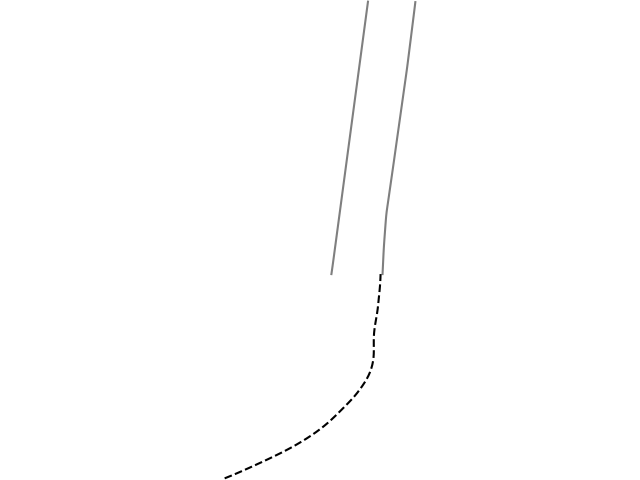

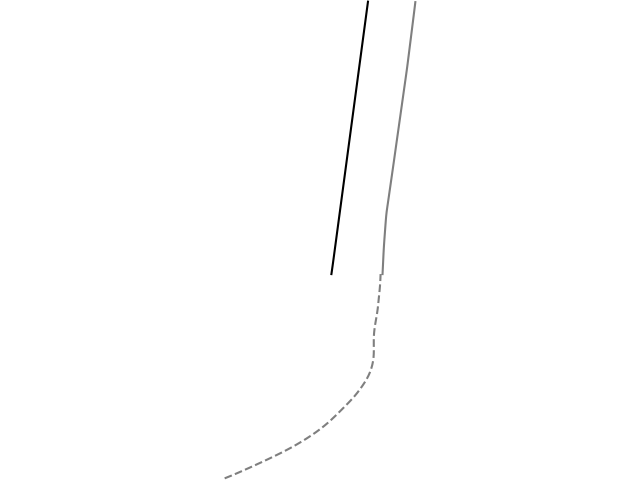

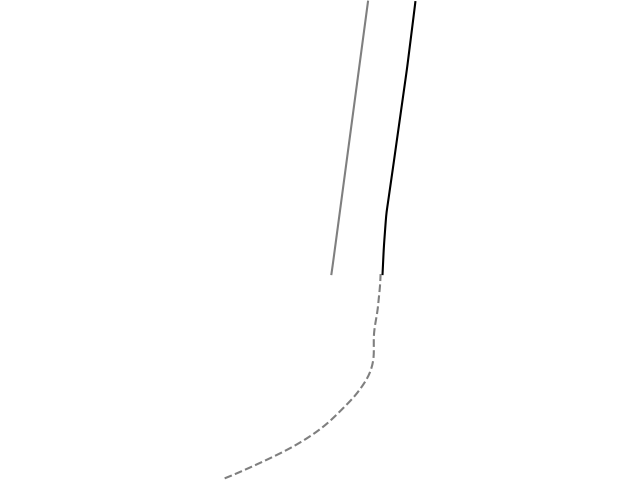

In [3]:
%autoreload 2
# %config InlineBackend.figure_formats = ['svg', 'png']
%matplotlib widget 
from utils import export_legend
plt.close('all')
idx_rand = int(np.random.randint(0, high=len(fulldset), size=1, dtype=np.int64)[0])
# idx_rand = 54662
# idx_rand = 7188
# idx_rand = 85723
idx_rand = 64652
# print(idx_rand)

sample : dict[str,np.ndarray] = fulldset[idx_rand].copy()
print(sample.keys())
rot = Rotation.from_rotvec([0.0, 0.0, np.pi/2.0])
mask = np.ones_like(sample["hist"])
mask[:,2] = 0.0

history = rot.apply(sample["hist"]*mask)[:,[0,1]]
ground_truth = rot.apply(sample["fut"]*mask)[:,[0,1]]
future_left_bd = rot.apply(sample["future_left_bd"]*mask)[:,[0,1]]
future_right_bd = rot.apply(sample["future_right_bd"]*mask)[:,[0,1]]

all_points = np.concatenate(([history, ground_truth, future_left_bd, future_right_bd]), axis=0)
dx = 0.0
dy = 0.0
minx, maxx = float(np.min(all_points[:,0])) - dx, float(np.max(all_points[:,0])) + dx
miny, maxy = float(np.min(all_points[:,1])) - dy, float(np.max(all_points[:,1])) + dy
aspect_ratio = 2.5*(maxx-minx)/(maxy-miny)

def plot_with_emphasis(*args : tuple[np.ndarray, dict], **kwargs):
    global minx, maxx, miny, maxy, aspect_ratio
    ax : matplotlib.axes.Axes = kwargs.get("ax", None)
    if ax is None:
        fig, ax = plt.subplots()
        rtn = (fig, ax)
    else:
        rtn = ax
    plot_kwargs = {k : v for (k,v) in kwargs.items() if k not in ["ax", "savepath"]}
    for arg in args:
        points, subdict =  arg
        subdict.update(plot_kwargs)
        ax.plot(points[:,0], points[:,1], **subdict)
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.set_aspect(aspect=aspect_ratio, adjustable="datalim")
    # ax.set_aspect("equal", "box")
    ax.axis("off")
    savepath = kwargs.get("savepath", None)
    fig.tight_layout(pad=0.01)
    if savepath is not None:
        fig.savefig(savepath, transparent=True, bbox_inches="tight")

    return rtn
alpha_emph = 1.0
alpha_nonemph = 0.5
fig, ax = plot_with_emphasis((history,         {"label": "History", "color" : "black", "linestyle" : "--", "alpha" : alpha_emph}),
                             (future_left_bd,  {"label": "Track Boundaries", "color" : "black",  "alpha" : alpha_nonemph }), 
                             (future_right_bd, {"color" : "black",  "alpha" : alpha_nonemph}), 
                             **{"savepath" : os.path.join(base_path, "history_highlighted.svg")}
                            )
fig2, ax2 = plot_with_emphasis((history,         {"label": "History", "color" : "black", "linestyle" : "--", "alpha" :   alpha_nonemph}),
                             (future_left_bd,    {"label": "Track Boundaries", "color" : "black",  "alpha" :  alpha_emph}), 
                             (future_right_bd,   {"color" : "black",  "alpha" : alpha_nonemph}), 
                             **{"savepath" : os.path.join(base_path, "left_bound_highlighted.svg")}
                            )
fig3, ax3 = plot_with_emphasis((history,         {"label": "History", "color" : "black", "linestyle" : "--", "alpha" : alpha_nonemph}),
                             (future_left_bd,    {"label": "Track Boundaries", "color" : "black",  "alpha" :  alpha_nonemph}), 
                             (future_right_bd,   {"color" : "black",  "alpha" : alpha_emph}), 
                             **{"savepath" : os.path.join(base_path, "right_bound_highlighted.svg")}
                            )
fig4, ax4 = plot_with_emphasis((history,        {"label": "History", "color" : "black", "linestyle" : "--", "alpha" : alpha_emph}),
                             (future_left_bd,   {"label": "Track Boundaries", "color" : "black",  "alpha" : alpha_emph }), 
                             (future_right_bd,  {"color" : "black",  "alpha" : alpha_emph}), 
                            )
fig_legend, ax_legend, bbox_legend = export_legend(ax4)
fig_legend.savefig(os.path.join(base_path, "legend.svg"), bbox_inches=bbox_legend, dpi="figure", transparent=True)
plt.close(fig=fig_legend)
plt.close(fig=fig4)


In [4]:
%autoreload 2
from utils import scatter_composite_axes, scatter_composite_xy
import matplotlib.transforms
import torch
from scipy.interpolate import BSpline, make_interp_spline
import deepracing_models.math_utils as mu
from matplotlib.markers import MarkerStyle
import matplotlib.axes
from matplotlib.axes import Axes
import matplotlib.transforms
idx_velplot = int(np.random.randint(0, high=len(fulldset), dtype=np.int64, size=(1,))[0])
# idx_velplot = 70836
# idx_velplot = 6196
# idx_velplot = 44916
# idx_velplot = 29441
# idx_velplot = 33974
# idx_velplot = 22451
# idx_velplot = 51389
# idx_velplot = 32508
# idx_velplot = 62948
# idx_velplot = 72289
print( "idx_velplot = %d" % (idx_velplot,))
sample_velplot = fulldset[idx_velplot]
mask = np.ones_like(sample_velplot["fut"])
mask[:,2] = 0.0
thistory : torch.Tensor = torch.as_tensor(sample_velplot["thistory"].copy(), dtype=torch.float64)
tfuture : torch.Tensor = torch.as_tensor(sample_velplot["tfuture"].copy(), dtype=thistory.dtype)
Rmat  = Rotation.from_rotvec([0.0, 0.0, 0.0], degrees=True)
Tvec : torch.Tensor = torch.zeros(3, dtype=thistory.dtype)
t0 = tfuture[0]
thistory = thistory - t0
tfuture = tfuture - t0

idxmiddle = int(round(tfuture.shape[0]/2))


hist_vel : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["hist_vel"]*mask), dtype=thistory.dtype))[:,[0,1]]
fut_vel : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["fut_vel"]*mask), dtype=thistory.dtype))[:,[0,1]]
fut : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["fut"]*mask), dtype=thistory.dtype) + Tvec)[:,[0,1]]
future_left_bd : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["future_left_bd"]*mask), dtype=thistory.dtype) + Tvec)[:,[0,1]]
future_right_bd : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["future_right_bd"]*mask), dtype=thistory.dtype) + Tvec)[:,[0,1]]
synthetic_sample = True

# pi = float(np.pi)
# thetadot_average = 2.0*pi/tfuture[-1]
# speed_average = 80.0
# radius = speed_average/thetadot_average

# thetadot_0 = .65*thetadot_average
# thetadot_max = 2*thetadot_average - thetadot_0

# thetadot_spline : BSpline = make_interp_spline(
#     [tfuture[0],      (tfuture[0] + tfuture[idxmiddle])/2.0,          tfuture[idxmiddle]],
#     [thetadot_0,      thetadot_max,                                   thetadot_0], k=1)
# theta_spline : BSpline = thetadot_spline.antiderivative()

# thetadot  =  torch.as_tensor(thetadot_spline(tfuture[:idxmiddle]), dtype=tfuture.dtype)
# theta     =  torch.as_tensor(theta_spline(tfuture[:idxmiddle]), dtype=tfuture.dtype)
# xdot_firsthalf =  (radius*thetadot*torch.sin(theta))
# ydot_firsthalf =  (radius*thetadot*torch.cos(theta))
# V_firsthalf = torch.stack([xdot_firsthalf, ydot_firsthalf], dim=1)
# # print(V_firsthalf)

# alphadot_spline : BSpline = make_interp_spline(
#     [tfuture[idxmiddle],      (tfuture[idxmiddle] + tfuture[-1])/2.0,          tfuture[-1]],
#     [thetadot_0,              thetadot_max,                                    thetadot_0], k=1)
# alpha_spline : BSpline = alphadot_spline.antiderivative()

# alphadot = torch.as_tensor(alphadot_spline(tfuture[idxmiddle:]), dtype=tfuture.dtype)
# alpha = torch.as_tensor(alpha_spline(tfuture[idxmiddle:]), dtype=tfuture.dtype)
# xdot_secondhalf = (radius*alphadot*torch.sin(alpha))
# ydot_secondhalf = -(radius*alphadot*torch.cos(alpha))
# V_secondhalf = torch.stack([xdot_secondhalf, ydot_secondhalf], dim=1)
# V_all = torch.cat([V_firsthalf, V_secondhalf], dim=0)
# velspline: BSpline = make_interp_spline(tfuture, V_all, k=3)
# posspline: BSpline = velspline.antiderivative()


# fut_vel : torch.Tensor = torch.as_tensor(velspline(tfuture), dtype=tfuture.dtype)
# fut_tangents = fut_vel/torch.norm(fut_vel, p=2, dim=1, keepdim=True)
# fut_normals  = fut_tangents[:,[1,0]].clone()
# fut_normals[:,0]*=-1.0

# fut : torch.Tensor = torch.as_tensor(posspline(tfuture), dtype=tfuture.dtype)
# synthetic_sample = True



idx_velplot = 19142


[0.02881979 0.81447868]
torch.Size([3, 5, 2])
torch.Size([3])
CompositeGenericTransform(
    TransformWrapper(
        BlendedAffine2D(
            IdentityTransform(),
            IdentityTransform())),
    CompositeGenericTransform(
        BboxTransformFrom(
            TransformedBbox(
                Bbox(x0=-1.1266512152622363, y0=-48.28885505939252, x1=37.966319592756015, y1=10.999197941318725),
                TransformWrapper(
                    BlendedAffine2D(
                        IdentityTransform(),
                        IdentityTransform())))),
        BboxTransformTo(
            TransformedBbox(
                Bbox(x0=0.125, y0=0.10999999999999999, x1=0.9, y1=0.88),
                BboxTransformTo(
                    TransformedBbox(
                        Bbox(x0=0.0, y0=0.0, x1=7.16, y1=4.027500000000001),
                        Affine2D().scale(100.0)))))))


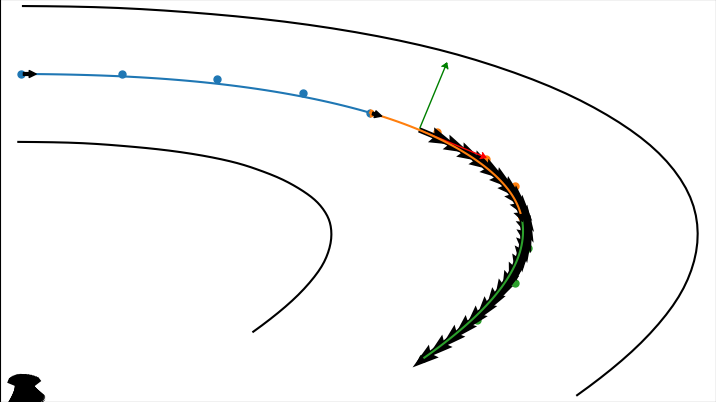

In [161]:
%autoreload 2
%matplotlib widget
import  matplotlib.patches
import matplotlib.transforms
import matplotlib.collections
import utils 
#scatter_composite_axes, .scatter_composite_xy
plt.rcParams["savefig.format"] = "pgf"

fut_speed = torch.norm(fut_vel, p=2.0, dim=1)
with_speed = False
try:
    plt.close("all")
except:
    pass
fig_vels, _axlist_ = plt.subplots(nrows=2 + int(with_speed), ncols=1)
axlist : list[Axes] = [ax for ax in _axlist_]
ax_velx = axlist[0]
ax_vely = axlist[1]
ax_speed = axlist[2] if with_speed else None

gt_artist, = ax_velx.plot(tfuture, fut_vel[:,0], label=r"$\boldsymbol{\nu}$", color="grey", linestyle="--")
ax_vely.plot(tfuture, fut_vel[:,1], label=gt_artist.get_label(), color=gt_artist.get_color(), linestyle=gt_artist.get_linestyle())
if ax_speed is not None:
    ax_speed.plot(tfuture, fut_speed)

# barte_curve : np.ndarray = composite_results["curves"][idx_velplot]
# nsegments = barte_curve.shape[0]
# kbezier = barte_curve.shape[1] - 1

numsegments = 3
kbezier = 3
dt = float(tfuture[-1]/numsegments)

# barte_pos_curve, tswitch = mu.compositeBezierFit(tfuture, fut, numsegments=numsegments, kbezier = kbezier+1, constraint_level=2)#, dYdT_0=fut_vel[0], dYdT_f=fut_vel[-1])
# barte_vel_curve = kbezier*(barte_pos_curve[:,1:] - barte_pos_curve[:,:-1])/dt

barte_vel_curve, tswitch = mu.compositeBezierFit(tfuture, fut_vel, numsegments=numsegments, kbezier = kbezier, constraint_level=1)
dtvec = tswitch[1:] - tswitch[:-1]
barte_pos_curve = mu.compositeBezierAntiderivative(barte_vel_curve[None], dtvec[None])[0]

if synthetic_sample:
    fut_tangents, idxbuckets = mu.compositeBezierEval(tswitch[:-1], dtvec, barte_vel_curve, tfuture)
    fut_tangents/=torch.norm(fut_tangents, p=2, dim=1, keepdim=True)
    fut_normals  = fut_tangents[:,[1,0]].clone()
    fut_normals[:,0]*=-1.0
    future_left_bd = fut + 10.0*fut_normals
    future_right_bd = fut - 10.0*fut_normals
else:
    future_left_bd : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["future_left_bd"]*mask), dtype=thistory.dtype) + Tvec)[:,[0,1]]
    future_right_bd : torch.Tensor = (torch.as_tensor(Rmat.apply(sample_velplot["future_right_bd"]*mask), dtype=thistory.dtype) + Tvec)[:,[0,1]]


idxskip = None
# barte_vel_curve = torch.as_tensor((float(kbezier)/dt)*(barte_curve[:,1:]-barte_curve[:,:-1]), dtype=torch.float64)
# idxskip = 6

tscatter : torch.Tensor = torch.cat(
    [ torch.linspace(tswitch[i], tswitch[i+1], steps=kbezier+1, dtype=tswitch.dtype)[1:] for i in range(tswitch.shape[0]-1) ],
    dim = 0
)
tscatter = torch.cat([tswitch[[0,]], tscatter], dim=0)
velcurve_x_plot = torch.cat([fut_vel[0,0].unsqueeze(0), barte_vel_curve[:,1:,0].reshape(-1)], dim=0)
velcurve_y_plot = torch.cat([fut_vel[0,1].unsqueeze(0), barte_vel_curve[:,1:,1].reshape(-1)], dim=0)
velplot_colors, velplot_artists = utils.scatter_composite_axes(barte_vel_curve, tswitch, [ax_velx, ax_vely], marker="*", **{"s": 8**2})

v0 = fut_vel[0].clone()
v0x = v0[0].item()
v0hline = ax_velx.hlines(v0x, 
                tswitch[0].item(),
                tswitch[-1].item(),
                color="black", linestyle="--", label="$\\mathbf{v}_{0}$")
v0y = v0[1].item()
ax_vely.hlines(v0y, 
            tswitch[0].item(),
            tswitch[-1].item(),
            color=v0hline.get_color(), linestyle=v0hline.get_linestyle(), label="$\\mathbf{v}_{0}$")
for i in range(numsegments):
    segment = barte_vel_curve[i,1:]
    deltas = torch.abs(segment - v0)
    midpoints = (segment + v0)/2.0
    tslice = torch.linspace(tswitch[i], tswitch[i+1], steps=kbezier+1)[1:].cpu()   
    ax_velx.errorbar(tslice, midpoints[:,0], deltas[:,0]/2, fmt='', linewidth=1, capsize=6, linestyle='', color=velplot_colors[i], label=r"$\Delta{\boldsymbol{\nu}}_" + str(i) + "$")
    ax_vely.errorbar(tslice, midpoints[:,1], deltas[:,1]/2, fmt='', linewidth=1, capsize=6, linestyle='', color=velplot_colors[i], label=r"$\Delta{\boldsymbol{\nu}}_" + str(i) + "$")

fig_vels.tight_layout(pad=0.75)
figure_aspect_ratio = 16.0/9.0
width = 7.16
height = width/figure_aspect_ratio
figsize = (width, height)

fig_pos, ax_pos = plt.subplots(figsize=figsize)
ax_pos.margins(x=0, y=0)
affinemat = torch.eye(3, dtype=barte_pos_curve.dtype, device=barte_pos_curve.device)
affinemat[0:2,0:2] = torch.as_tensor(Rmat.as_matrix()[0:2,0:2], dtype=barte_pos_curve.dtype, device=barte_pos_curve.device)
affinemat[0:2,2] = Tvec[0:2]
transform : matplotlib.transforms.Affine2D = matplotlib.transforms.Affine2D(affinemat.cpu().numpy().copy()).inverted()

affinemat2 = np.eye(3)
# affinemat2[0:2,0:2] = Rotation.from_rotvec([0.0, 0.0, 90.0], degrees=True).as_matrix()[0:2,0:2]
rotated = not np.allclose(affinemat2, np.eye(3))
affinetransform : matplotlib.transforms.Affine2D = matplotlib.transforms.Affine2D(affinemat2.copy())
transform : matplotlib.transforms.Affine2D =  transform + affinetransform

tstart = tswitch[:-1]
tend = tswitch[1:]
dt = tend - tstart
# tarrows = tswitch[[0,]]
# tarrows = torch.cat([tarrows, tstart + dt/4.0], dim=0)
# tarrows = torch.cat([tarrows, tstart + 3.0*dt/4.0], dim=0)
# tarrows = tarrows[torch.argsort(tarrows)]
tarrows = torch.linspace(tswitch[0].item(), tswitch[-1].item(), steps=numsegments+1, device=tswitch.device, dtype=tswitch.dtype)
kwargs = {"s" : 5**2,  "colors" : velplot_colors,
          "tplot" : torch.linspace(tswitch[0].item(), tswitch[-1].item(), steps=120, device=tswitch.device, dtype=tswitch.dtype),
          "tarrows" : tarrows,
          "tswitch" : tswitch,
          "tannotate" : torch.as_tensor([1.6417], device=tswitch.device, dtype=tswitch.dtype),
        #   "transform" : transform + ax_pos.transData
          }
# barte_pos_curve_transformed = barte_pos_curve
barte_pos_curve_transformed = torch.as_tensor(affinetransform.transform(barte_pos_curve.view(-1,2).cpu().numpy()), dtype=barte_pos_curve.dtype).reshape(barte_pos_curve.shape)

left_bound_transformed = torch.as_tensor(affinetransform.transform(future_left_bd.cpu().numpy()), device=barte_pos_curve.device, dtype=barte_pos_curve.dtype)
right_bound_transformed = torch.as_tensor(affinetransform.transform(future_right_bd.cpu().numpy()), device=barte_pos_curve.device, dtype=barte_pos_curve.dtype)

ax_pos.plot(left_bound_transformed[:,0], left_bound_transformed[:,1], color="black", label="Track\nBounds")
ax_pos.plot(right_bound_transformed[:,0], right_bound_transformed[:,1], color="black")
all_points = torch.cat([barte_pos_curve_transformed.view(-1,2), 
                        left_bound_transformed, right_bound_transformed], dim=0)

xmin, xmax = torch.min(all_points[:,0]).item() - 1.0, torch.max(all_points[:,0]).item() + 1.0
ax_pos.set_xlim(xmax, xmin) if rotated else ax_pos.set_xlim(xmin, xmax)

ymin, ymax = torch.min(all_points[:,1]).item() - 1.0, torch.max(all_points[:,1]).item() + 1.0
ax_pos.set_ylim(ymin, ymax)
#**-1
# aspect_ratio = (.65**(1 - 2*int(rotated)))*(xmax - xmin)/(ymax - ymin)
# ax_pos.set_aspect(aspect_ratio, "box")
_, points_plot, _ = utils.scatter_composite_xy(barte_pos_curve_transformed, ax_pos, quiver_kwargs = {"scale" : 2**3.5, "width" : 0.005,  "units" : "height" if rotated else "width", "headwidth" : 2.25 }, **kwargs)
fontsize=14
yaxisright=True
for ax in (axlist + [ax_pos,]):
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
# ax_pos.set_xlabel("Target-Centric Y position (m)", fontsize=fontsize)
# ax_pos.set_ylabel("Target-Centric X position (m)", fontsize=fontsize)
if yaxisright:
    ax_pos.yaxis.tick_right() 
    ax_pos.yaxis.set_label_position("right")
import matplotlib.font_manager as font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
    size=fontsize, weight='normal', stretch='normal')
for labels in [ax_pos.get_xticklabels(), ax_pos.get_yticklabels()]:
    for label in labels:
        label.set_fontproperties(ticks_font)
# axes_to_data = ax_pos.transAxes + ax_pos.transData.inverted()
# data_to_axes = axes_to_data.inverted()
data_to_axes = ax_pos.transLimits
axes_to_data = data_to_axes.inverted()
new_transforms = []
origin_ax = data_to_axes.transform(np.zeros(2))
print(origin_ax)
#widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2,
arrowprops =  dict(
    arrowstyle="->"
)
print(barte_pos_curve_transformed.shape)
print(dtvec.shape)
velcurve_transformed = (barte_pos_curve_transformed.shape[1]-1)*(barte_pos_curve_transformed[:,1:] - barte_pos_curve_transformed[:,:-1])/dtvec[:,None,None]
xy = barte_pos_curve_transformed[0,0].cpu().numpy()
xytext = xy + np.asarray([10.0, 0.0])
# annotation0 = ax_pos.annotate("$t=t_0$", xy, xytext = xytext, arrowprops=arrowprops).draggable()

unitvec_t = torch.linspace(1.2, 2.9, steps=25).type_as(tstart)
unitvecs, _ = mu.compositeBezierEval(tstart, dtvec, velcurve_transformed[:,:,[0,1]], unitvec_t)
unitvecs = (unitvecs/torch.linalg.norm(unitvecs, 2.0, dim=1, keepdim=True)).cpu()
angle_data = torch.atan2(unitvecs[0,1], unitvecs[0,0]).item() #, normalvec=True
unitvec_pos, _ = mu.compositeBezierEval(tstart, dtvec, barte_pos_curve_transformed[:,:,[0,1]], unitvec_t)
unitvec_pos = unitvec_pos.cpu()
arrowstyle = matplotlib.patches.ArrowStyle.CurveB(head_length=4.8, head_width=3.2)
normalvecs = unitvecs[:,[1,0]].clone()
normalvecs[:,0]*=-1.0

tv : utils.UnitVector = ax_pos.add_patch(utils.UnitVector(unitvec_pos[0].numpy(), angle_data, offset_figure=[0.75, 0.0], arrowstyle=arrowstyle, color="red"))
nv : utils.UnitVector = ax_pos.add_patch(utils.UnitVector(unitvec_pos[0].numpy(), angle_data, offset_figure=[0.0, 0.75], arrowstyle=arrowstyle, color="green"))

%matplotlib widget
ax_pos.get_xaxis().set_visible(False)
ax_pos.get_yaxis().set_visible(False)
# ax_pos.legend(frameon=False)
# ax_pos.set_title("Position Curve, $\\mathbf{B}$\n(Integral of Velocity Curve, $\\boldsymbol{\\nu}$", fontsize=fontsize)
fig_pos.tight_layout(pad=0.0)
fig_pos.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,  hspace = 0, wspace = 0)
with plt.rc_context({"svg.fonttype" : 'none', "text.usetex" : True, "savefig.transparent" : True, "savefig.pad_inches" : 0.0, "savefig.bbox" : "tight", "savefig.orientation" : "landscape"}) as ctx:
    fig_pos.savefig(os.path.join(base_path, "pos.svg"))
    fig_pos.savefig(os.path.join(base_path, "pos.eps"))
    fig_pos.savefig(os.path.join(base_path, "pos.pdf"))
# plt.close(fig=fig_pos)
fig_legend, ax_legend, bbox_legend = export_legend(ax_pos, fontsize=14, ncols=5, columnspacing=0.5, handletextpad=0.1)
fig_legend.savefig(os.path.join(base_path, "pos.legend.svg"), bbox_inches=bbox_legend, dpi="figure", transparent=True)
plt.close(fig=fig_legend)

fig_vels.savefig(os.path.join(base_path, "vel.svg"), transparent=True,  pad_inches=0.0)
fig_legend, ax_legend, bbox_legend = export_legend(ax_vely, fontsize=14, ncols=5, columnspacing=0.5, handletextpad=0.1)
fig_legend.savefig(os.path.join(base_path, "vel.legend.svg"), bbox_inches=bbox_legend, dpi="figure", transparent=True)
plt.close(fig=fig_legend)
plt.close(fig=fig_vels)

In [ ]:
plt.close("all")
A = [ {"label" : "Inner Boundary", "linestyle" : "dashed"},
      {"label" : "Outer Boundary", "linestyle" : "dashed"} ,
      {"label" : "Centerline", "linestyle" : "dashed"},
      {"label" : "Raceline", "linestyle" : "dashed"},
      {"label" : "Mixed Bézier Curve", "linestyle" : "solid", "color" : "black"}], False
B = [
    {"label" : "$\\mathrm{\\nu_t}$",  "linestyle" : "dashed", "color" : "green"},
    {"label" : "Bernstein\nCoefficients",  "marker" : "+", "color" : "green"}
    ], True
C = [d.copy() for d in A[0]], A[1]
C[0][-1]["label"] = "Ground Truth"
D = [
    {"label" : "$\\mathdefault{\\mathbf{B}_0}$",  "linestyle" : "solid", "color" : "C0"},
    {"label" : "$\\mathdefault{\\mathbf{B}_1}$",  "linestyle" : "solid", "color" : "C1"},
    {"label" : "$\\mathdefault{\\mathbf{B}_2}$",  "linestyle" : "solid", "color" : "C2"},
    {"label" : "Current Velocity",  "linestyle" : "dashed", "color" : "grey"}
    ], True     
E = [
    {"label" : "Track Boundaries",  "linestyle" : "dashed", "color" : "grey"},
    {"label" : "Ground Truth",  "marker" : None, "color" : "blue"},
    {"label" : "Predictions",  "marker" : None, "color" : "red"}
    ], False            

config = D
labels= config[0]
usetex = config[1]
with plt.rc_context({"text.usetex" : usetex, "font.family" : "serif"}):
    empty_figure, empty_axes = plt.subplots()
    for (idx, entry) in enumerate(labels):
        linestyle = entry.get("linestyle", None)
        if linestyle is not None:
            empty_axes.plot([], [], **entry)
        else:
            empty_axes.scatter([], [], **entry)
    fig_legend, ax_legend, bbox_legend = export_legend(empty_axes, fontsize=16, ncols=1, columnspacing=0.1, labelspacing=0.25, handletextpad=0.00)
    fig_legend.savefig(os.path.join(base_path, "asdf.legend.svg"), bbox_inches=bbox_legend, dpi="figure", transparent=True)
    fig_legend.savefig(os.path.join(base_path, "asdf.legend.eps"), bbox_inches=bbox_legend, dpi="figure", transparent=True)
    plt.close(fig=empty_figure)
    plt.close(fig=fig_legend)

